<a href="https://colab.research.google.com/github/lawrencegranda/garbage_segmentation/blob/main/predictions_and_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Garbage Segmentation Model 005**

---



## Install and import dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install tensorflow
! pip install matplotlib
! pip install pandas
! pip install patchify
! pip install segmentation-models

from patchify import patchify, unpatchify

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, InputLayer, Lambda, Conv2DTranspose
from tensorflow.keras.layers import Concatenate, UpSampling2D, BatchNormalization, Concatenate, ReLU, Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3

import keras
from keras.metrics import MeanIoU

import segmentation_models as sm

import numpy as np
import pandas as pd
import random
import os
import PIL
import glob
import matplotlib.pyplot as plt
import os.path
import argparse
import json
from PIL import Image
import requests
from io import BytesIO
import sys
import cv2
from skimage import io

from matplotlib.path import Path
import matplotlib.patches as patches
from urllib.request import urlopen
import json
from time import time
import pickle


!pip install google-colab
from google.colab import output
output.clear()

## Hyperparameters

In [ ]:
ORIGINAL_RES = 576
RES = ORIGINAL_RES//2

BATCH_SIZE = 4
SLICES = 3

THRESHOLD = 0.9

FOLDER_PATH = './drive/MyDrive/ColabNotebooks/GARBAGE_DETECTION/'
MODEL_PATH = os.path.join(FOLDER_PATH, 'my_models005')
IMGS_FILE = 'imgs.pickle'
MODEL_NAME = 'GARBAGE_SEG005'
WEIGHTS_PATH = os.path.join(MODEL_PATH, 'weights', 'checkpoint')

LEARNING_RATE = 5e-6
EPOCHS = 20
PATIENCE = 5
VERBOSE = 1

IMGS_PATH = os.path.join(FOLDER_PATH, IMGS_FILE)

## Info

In [ ]:
info = {
    'batch_size': BATCH_SIZE,
    'train': None,
    'val': None,
    'test': None,
    'res': RES,
    'image_shape': (RES,RES,3),
    'masks_shape': (RES,RES,1),
}

## Building u-Net model


### Losses + Metrics

In [ ]:
def get_loss(factor=1):
    dice_loss = sm.losses.DiceLoss()
    focal_loss = sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + (factor * focal_loss)

    return total_loss

def get_metrics(thr=0.5):
    iou = sm.metrics.IOUScore(threshold=thr)
    fscore = sm.metrics.FScore(threshold=thr)
    metrics = [iou, fscore]

    return metrics

### Architecture

In [ ]:
def get_params(model, verbose=1):
    trainable = 0
    for v in model.trainable_variables:
        shape = v.get_shape()
        count = 1
        for dim in shape:
            count *= dim
            trainable += count

    total = 0
    for v in model.variables:
        shape = v.get_shape()
        count = 1
        for dim in shape:
            count *= dim
            total += count

    params = {'trainable': trainable, 'non-trainable': total-trainable, 'total': total}

    if verbose > 0:
        print(f'Trainable: {params["trainable"]:,}')
        print(f'Non-trainable: {params["non-trainable"]:,}')
        print(f'Total: {params["total"]:,}')

    return {'trainable':trainable, 'non-trainable':total-trainable, 'total':total}

In [ ]:
def build_unet(input_shape):
    FILTERS = 16

    def conv_op(input, filters):
        conv1 = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(input)
        bn1 = BatchNormalization()(conv1)
        act1 = ReLU()(bn1)

        conv2 = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(act1)
        bn2 = BatchNormalization()(conv2)
        act2 = ReLU()(bn2)
        return act2


    def decoder(input, skip, filters):
        upsample = Conv2DTranspose(filters=filters, kernel_size=(2, 2), strides=(2,2), padding='same')(input)
        connect_skip = Concatenate()([upsample, skip])
        connect_skip = Dropout(0.4)(connect_skip)   # DROPOUT
        dec_conv =  conv_op(connect_skip, filters)
        return dec_conv


    """ Input layer """
    inputs = tf.keras.Input(shape=input_shape, name="input")

    """ Encoder (pre-trained) """
    encoder = EfficientNetB3(weights='imagenet', include_top=False, input_tensor=inputs)
    # do not train pre-trained layers
    for layer in encoder.layers:
        layer.trainable = False

    skip1 = encoder.get_layer('stem_conv_pad').input                    # 288 x 288
    skip2 = encoder.get_layer('block2a_expand_activation').output       # 144 x 144
    skip3 = encoder.get_layer('block3a_expand_activation').output       # 72 x 72
    skip4 = encoder.get_layer('block4a_expand_activation').output       # 36 x 36


    """ Bottleneck """
    conv_block = encoder.get_layer('block6a_expand_activation').output  # 18 x 18

    """ Decoder """
    dec1 = decoder(input=conv_block, skip=skip4, filters=FILTERS*8)     # 36 x 36
    dec2 = decoder(input=dec1, skip=skip3, filters=FILTERS*4)           # 72 x 72
    dec3 = decoder(input=dec2, skip=skip2, filters=FILTERS*2)           # 144 x 144
    dec4 = decoder(input=dec3, skip=skip1, filters=FILTERS)             # 288 x 288

    output = Conv2D(filters=1, kernel_size=(1, 1), padding='same', activation='sigmoid', name="output")(dec4)


    model_title = "uNet"
    model = tf.keras.Model(inputs, output, name=model_title)

    return model

In [ ]:
def get_model(factor, lr, verbose=0, find=True, load_weights=True, compile=True):
    
    if find:
        try:
            model_list = os.listdir(os.path.join(MODEL_PATH, 'models'))
            model_list.sort(reverse=True)
            model = tf.keras.models.load_model(os.path.join(MODEL_PATH, 'models', model_list[0]), compile=False)
            print("Model found.", end=' ')
        except (FileNotFoundError, IndexError, OSError):
            find = False
    
    if not find:
        model = build_unet(input_shape=info['image_shape'])
        print("Model created.", end=' ')
        
        if load_weights:
            try:
                model.load_weights(WEIGHTS_PATH)
                print("Weights found.", end=' ')
            except (FileNotFoundError, IndexError, OSError, tf.errors.NotFoundError):
                pass


    if compile:
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                    loss=get_loss(factor),
                    metrics=get_metrics(thr=THRESHOLD),
                    )
        print("Model compiled.", end=' ')


    print()


    if verbose > 0:
        _ = get_params(model)

    if verbose > 1:
        tf.keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True, dpi=60)


    return model

## Load dataset

### Get from GitHub

In [ ]:
def get_from_github():
    ! rm -r ./sample_data/
    ! git clone https://github.com/pedropro/TACO.git

    dataset_path = './TACO/data/annotations.json'

    # Read annotations
    with open(dataset_path, 'r') as f:
        dataset = json.loads(f.read())

    ! rm -r ./TACO
    
    output.clear()

    return dataset

In [ ]:
def get_dataframes(dataset):
    cats = pd.DataFrame(dataset['categories'])
    cats = cats.rename(columns={"supercategory": "super"})
    cats = cats.set_index(['id'])
    cats = cats.sort_values(by=['id', 'super'])

    my_cats = ['Aluminium foil', '	Plastic bag & wrapper', 'Cigarette', 'Unlabled litter',
            'Bottle','Bottle cap', 'Can', 'Other plastic','Carton', 'Cup', 'Straw',
            'Paper', 'Broken glass', 'Styrofoam piece', 'Plastic container', 'Food waste']
    cats["used"] = cats["super"].apply(lambda x: x in my_cats)

    mapping = {item: i for i, item in enumerate(cats["super"].unique())}
    mapping = {item: i for i, item in enumerate(cats.sort_values(by=['used'], ascending=False)['super'].unique())}
    cats["super_id"] = cats["super"].apply(lambda x: mapping[x])


    anns = pd.DataFrame(dataset['annotations'])
    anns = anns[['image_id', 'category_id', 'segmentation']]
    anns = anns.rename(columns={"image_id": "id", "category_id": "category", "segmentation":"seg"})

    anns = anns[cats['used'][anns['category']].to_numpy()]
    anns['seg'] = anns['seg'].apply(lambda x: [ int(e) for e in x[0] ])

    anns['category'] = anns['category'].apply(lambda x: cats['super_id'][x])

    anns = anns.sort_values(by=['id', 'category'])
    anns = anns.reset_index(drop=True)


    imgs = pd.DataFrame(dataset['images'])
    imgs = imgs[['id', 'flickr_url', 'width', 'height']]
    imgs = imgs.rename(columns={"flickr_url": "url"})
    imgs = imgs.set_index(['id'])
    imgs = imgs.sort_values(by=['id'])
    imgs = imgs.loc[anns['id'].unique()]    # get only the ones that have any annotations
    imgs['cat'] = imgs.apply(lambda x: np.array(anns[anns['id'] == x.name]['category']), axis=1)
    imgs['seg'] = imgs.apply(lambda x: np.array(anns[anns['id'] == x.name]['seg']), axis=1)
    # imgs = imgs.sample(frac=1)   # shuffle images
    imgs = imgs.reset_index(drop=True)

    return imgs, cats

### Load images

#### define functions

##### pickle

In [ ]:
import gc

def garbage():
    gc.collect(generation=0)
    gc.collect(generation=1)
    gc.collect(generation=2)
    return

In [ ]:
def pickle_exists(path):
    try:
        with open(path, 'rb') as input_file:
            pickle.load(input_file)
        garbage()
        return True
    except FileNotFoundError:
        return False


def save_pickle(dataset, path, overwrite=False):
    if not overwrite and pickle_exists(path):
        raise PermissionError('Not allowed to overwrite file. Must pass "overwrite=True".')
        return False

    with open(path, 'wb') as output_file:
        pickle.dump(dataset, output_file)

    return True


def load_pickle(path):
    with open(path, 'rb') as input_file:
        dataset = pickle.load(input_file)

    return dataset

##### images

In [ ]:
def image_from_url(url):
    try:
        url = url.numpy().decode("utf-8")
    except AttributeError:
        url = url

    with urlopen(str(url)) as request:
        img_array = np.asarray(bytearray(request.read()), dtype=np.uint8)

    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (ORIGINAL_RES,ORIGINAL_RES))

    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
def process_images(urls):
    images = []

    start = time()

    for i, url in enumerate(urls):
        if i%400 == 0 and i!=0:
            at = (time()-start)/i
            print(f'\nExpected: {(len(urls)-i)*at/60:.0f}')
        if i%20 == 0:
            print(i, end=" ")

        images.append(image_from_url(url))

    print(f'\nTime: {(time()-start)/60:.0f}')
    output.clear()

    return images

In [ ]:
def read_image_from_url(url):
    return tf.reshape(tf.py_function(image_from_url, [url], tf.uint8), [ORIGINAL_RES, ORIGINAL_RES, 3])

##### masks

In [ ]:
def get_mask(res, dim, points, category):

    xs, ys = zip(*points) #create lists of x and y values
    xs = np.array(xs)*(res/dim[0])
    ys = np.array(ys)*(res/dim[1])

    polygon = np.array(list(zip(xs, ys)), dtype=np.uint16)

    patch = patches.PathPatch(Path(polygon))

    x, y = np.meshgrid(np.arange(res), np.arange(res))
    x, y = x.flatten(), y.flatten()
    p = list(zip(x, y))

    mask = patch.contains_points(p)
    mask = np.array(mask, dtype=bool)
    mask = mask.reshape((res,res))

    return mask

def get_all_masks(im, res):
    masks = np.zeros((res, res, 14), dtype=bool)
    
    cats = im['cat']
    seg = im['seg']
    for cat, polygon in zip(cats, seg):
        points = np.reshape(polygon, (-1,2))
        masks[:,:, cat] = np.logical_or(masks[:,:, cat], get_mask(res, (im['width'], im['height']), points, cat))

    return np.expand_dims(masks.max(axis=-1), axis=-1)

In [ ]:
def process_masks(dataset):
    masks = []

    start = time()

    i = 0
    for _, row in dataset.iterrows():
        if i%400 == 0 and i!=0:
            at = (time()-start)/i
            print(f'\nExpected: {(len(dataset)-i)*at/60:.0f}')
        if i%20 == 0:
            print(i, end=" ")

        masks.append(get_all_masks(row, ORIGINAL_RES))
        i+=1

    print(f'\nTime: {(time()-start)/60:.0f}')
    output.clear()

    return masks

##### patching

In [ ]:
def patch_multiple(images, res):
    channels = images[0].shape[-1]
    imgs = []

    for i, im in enumerate(images):
        if i%50 == 0:
            print(i, end=" ")

        tmpIm = patchify(im, (res,res,channels), res)
        imgs.append(tmpIm)

    return np.array(imgs, dtype=np.uint8).reshape(-1,res,res,channels)

In [ ]:
def patch_image_from_tensor(im, channels):
    return tf.py_function(patchify, [im, (RES, RES, channels), RES], tf.uint8)

##### help functions

In [ ]:
def load_all_images(imgs_path, data, piece, slices, patch):

    try:
        with open(imgs_path, 'rb') as input_file:
            images = pickle.load(input_file)

        assert np.array(images[0]).shape[-2] == ORIGINAL_RES
        print('Images loaded successfully.')

    except (FileNotFoundError, AssertionError):
        print('Images not found. Creating...')
        images = process_images(data['url'])
        save_pickle(images, imgs_path, overwrite=True)
        print('Images saved and loaded successfully.')

    images = images[piece-1::slices]
    garbage()

    if patch:
        print(f'Patching {len(images)} images...')
        images = patch_multiple(images, RES)
        garbage()

    print(f'\nImages generated successfully. Shape: {images.shape}')

    tf.random.set_seed(1)
    images = tf.data.Dataset.from_tensor_slices(images).shuffle(len(images), reshuffle_each_iteration=False, seed=1)
    garbage()

    return images

In [ ]:
def load_all_masks(data, piece, slices, patch):
    print('Creating masks...')
    data = data[piece-1::slices]
    masks = process_masks(data)

    
    garbage()

    if patch:
        print(f'Patching {len(masks)} masks...')
        masks = patch_multiple(masks, RES)
        garbage()

    print(f'\nMasks generated successfully. Shape: {masks.shape}')

    tf.random.set_seed(1)
    masks = tf.data.Dataset.from_tensor_slices(masks).shuffle(len(masks), reshuffle_each_iteration=False, seed=1)
    garbage()

    return masks

In [ ]:
def get_data(imgs_path, piece=1, slices=1, patch=True):
    assert piece <= slices

    data = get_dataframes(get_from_github()) [0]
    print(f'{len(data)} images and masks to load.')

    images = load_all_images(imgs_path, data, piece, slices, patch)
    masks = load_all_masks(data, piece, slices, patch)

    assert len(masks) == len(images)
    dataset = tf.data.Dataset.zip((images, masks)).cache()

    print(f'\nDataset created successfully. Size: {len(dataset)}')

    return dataset

#### Images: Train-Validation-Test Split + Augmentation

In [ ]:
def augment(imgen, image, masks):
    seed = np.random.randint(10000)

    return tf.reshape(tf.py_function(imgen.random_transform, [image, seed], tf.float32), [RES, RES, 3]),  tf.reshape(tf.py_function(imgen.random_transform, [masks, seed], tf.float32), [RES, RES, 1])

In [ ]:
def test_train_split(dataset):
    dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))

    total = len(dataset)

    train_size = int(0.7 * total)
    val_size = int(0.15 * total)
    test_size = total - (train_size + val_size)

    train_dataset = dataset.take(train_size)
    test_dataset = dataset.skip(train_size)
    val_dataset = test_dataset.take(val_size)
    test_dataset = test_dataset.skip(val_size)

    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.3,
        fill_mode='constant',
        cval=0,
        horizontal_flip=True,
        vertical_flip=True,
        dtype=tf.float32
    )

    train_dataset = train_dataset.map(lambda image, masks: augment(train_gen, image, masks)).batch(info['batch_size']).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(info['batch_size']).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(info['batch_size']).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, val_dataset, test_dataset

In [ ]:
def get_split_dataset(piece):
    dataset = get_data(imgs_path=IMGS_PATH, piece=piece, slices=SLICES)
    train_dataset, val_dataset, test_dataset = test_train_split(dataset)

    output.clear()
    garbage()

    info['train'] = len(train_dataset) * info['batch_size']
    info['val'] = len(val_dataset) * info['batch_size']
    info['test'] = len(test_dataset) * info['batch_size']

    return train_dataset, val_dataset, test_dataset

## Training + Evaluation Functions

### Training Functions

In [ ]:
def save_model(model):
    time = str(datetime.now())[0:16].replace(' ','_').replace(':','h')
    file_path = f'{MODEL_PATH}/models/{MODEL_NAME}_{time}.h5'
    
    model.save(file_path, overwrite=True)
    print(f'\nModel saved in {file_path}')

    return

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        print("Starting training \n")

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("\n\nEnd of training\nThe validation loss is {:.4f}"
        .format(logs["val_loss"]))

    def on_epoch_end(self, epoch, logs=None):
        if epoch%15==0 and epoch>0:
            save_model(self.model)
        elif epoch%5==0 and epoch>0:
            time = str(datetime.now())[0:16].replace(' ','_').replace(':','h')
            self.model.save_weights(MODEL_PATH+'/weights/{}_{}_iter{}{}.ckpt'.format(MODEL_NAME, time, epoch//10, epoch%10))
        
        if VERBOSE<=0:
            if epoch%5 == 0 and epoch>0:
                keys = list(logs.keys())
                print("\nThe validation loss is {:.4f}".format(logs["val_loss"]))

            print(epoch+1, end=" ")


class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        print("Starting training \n")

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("\n\nEnd of training\nThe validation loss is {:.4f}"
        .format(logs["val_loss"]))

    def on_epoch_end(self, epoch, logs=None):        
        if VERBOSE<=0:
            if epoch%5 == 0 and epoch>0:
                keys = list(logs.keys())
                print("\nThe validation loss is {:.4f}".format(logs["val_loss"]))

            print(epoch+1, end=" ")


stopper = EarlyStopping(monitor='val_loss', patience=PATIENCE)
checkpointer = ModelCheckpoint(filepath=WEIGHTS_PATH, monitor="val_loss", mode='min', verbose=0, save_best_only=True)

In [ ]:
from datetime import datetime

def train(model, train, val):
    history = model.fit(
        train,
        validation_data=val,
        epochs=EPOCHS,
        verbose=VERBOSE,
        callbacks=[stopper, checkpointer, CustomCallback()]
        )

    # Save the entire model
    save_model(model)

    return model, history.history

In [ ]:
def set_trainable(model, tunning=False, verbose=1):

    for layer in model.layers:
        layer.trainable = tunning

    for layer in model.layers[-37:]:
        layer.trainable = not tunning

    for layer in model.layers:
        if 'batchnormalization' in  str(type(layer)).lower():
            layer.trainable = False

    if verbose:
        get_params(model)

    return model

### Evaluation Functions

In [ ]:
def evaluate(myModel, dataset, channel=1, start=1, threshold=0.5):
    dataset = dataset.map(lambda x, y: (tf.cast(x, tf.uint16), tf.cast(y, tf.uint16)))

    from tensorflow.python.ops.numpy_ops import np_config
    np_config.enable_numpy_behavior()

    plt.figure(figsize=(20,6))

    iterator = dataset.take(1).as_numpy_iterator().next()
    start = start % (BATCH_SIZE - 7)

    i = 0
    for image, masks, preds in zip(iterator[0], iterator[1], myModel.predict(iterator[0])):
        if i >= start+7:
            plt.show()
            break

        elif i >= start:
            idx = i-start
            plt.subplot(3,7,idx+1)
            plt.imshow(image)

            plt.subplot(3,7,idx+8)
            plt.imshow(masks[:,:,channel])

            plt.subplot(3,7,idx+15)
            plt.imshow(preds[:,:,channel] > threshold)

        i+=1

    del iterator, i

In [ ]:
def plotLoss(history):
    loss = np.log1p(np.sqrt(history['loss']))
    val_loss = np.log1p(history['val_loss'])

    plt.figure(figsize=(6, 3))

    epochs_range = range(len(loss))
    plt.plot(epochs_range, loss, label='Training Loss', c='blue')
    plt.plot(epochs_range, val_loss, label='Validation Loss', c='red')

    plt.title('Training and Validation Losses')
    plt.show()

## Training

In [ ]:
myModel = set_trainable(get_model(factor=7, lr=LEARNING_RATE), tunning=False)

Model found. Model compiled. 
Trainable: 1,348,550
Non-trainable: 2,502,079
Total: 3,850,629


Model created. Weights found. Model compiled. 
Starting training 

Epoch 1/20
275/275 [==============================] - 119s 432ms/step - loss: 0.5916 - iou_score: 0.4000 - f1-score: 0.4955 - val_loss: 0.4441 - val_iou_score: 0.5942 - val_f1-score: 0.6925
Epoch 2/20
275/275 [==============================] - 103s 373ms/step - loss: 0.5550 - iou_score: 0.4297 - f1-score: 0.5254 - val_loss: 0.4908 - val_iou_score: 0.5559 - val_f1-score: 0.6543
Epoch 3/20
275/275 [==============================] - 102s 371ms/step - loss: 0.5275 - iou_score: 0.4497 - f1-score: 0.5467 - val_loss: 0.5139 - val_iou_score: 0.5481 - val_f1-score: 0.6466
Epoch 4/20
275/275 [==============================] - 103s 376ms/step - loss: 0.5076 - iou_score: 0.4641 - f1-score: 0.5627 - val_loss: 0.5235 - val_iou_score: 0.5355 - val_f1-score: 0.6392
Epoch 5/20
275/275 [==============================] - 104s 378ms/step - loss: 0.4925 - iou_score: 0.4797 - f1-score: 0.5742 - val_loss: 0.6961 - val_iou_score: 0.3998 - val_

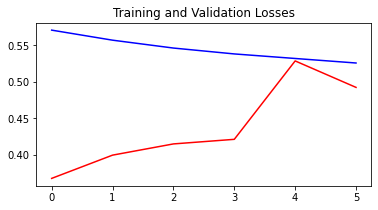

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
tf.config.run_functions_eagerly(True)

for i in range(SLICES):
    try:
        del train_dataset, val_dataset, test_dataset
    except NameError:
        pass

    train_dataset, val_dataset, test_dataset = get_split_dataset(i+1)

    myModel = set_trainable(get_model(factor=7, lr=LEARNING_RATE, find=False, load_weights=True), tunning=False, verbose=0)
    myModel, myHistory = train(myModel, train_dataset, val_dataset)
    
    plotLoss(myHistory)

Model created. Weights found. Model compiled. 


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


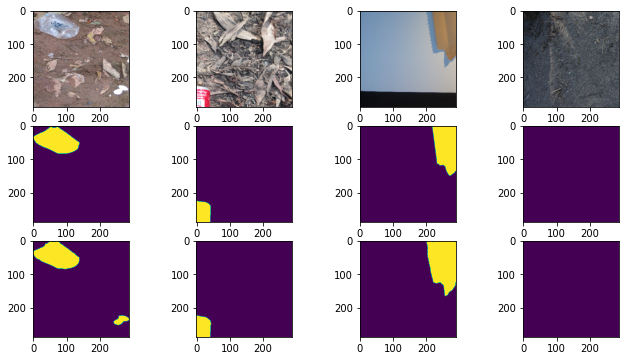

In [ ]:
myModel = set_trainable(get_model(factor=7, lr=LEARNING_RATE, find=False, load_weights=True), tunning=False, verbose=0)
evaluate(myModel, test_dataset, channel=0, start=0+7*2, threshold=THRESHOLD)

## Fine-Tunning

In [ ]:
myModel = set_trainable(get_model(factor=7, lr=LEARNING_RATE, find=False, load_weights=True), tunning=True)

43950080/43941136 [==============================] - 0s 0us/step
Model created. Weights found. Model compiled. 
Trainable: 2,428,857
Non-trainable: 1,421,772
Total: 3,850,629


In [ ]:
train_dataset, val_dataset, test_dataset = get_split_dataset(1)

evals = []

for thr in np.arange(start=40, stop=100, step=5):
    myModel.compile(metrics=get_metrics(thr=thr/100))
    evals.append(myModel.evaluate(val_dataset, return_dict=True, verbose=0))

THRESHOLD = pd.DataFrame(evals)['f1-score'].argmax()*0.05+0.5
print(f'Threshold updated to {THRESHOLD}')

print()

_ = myModel.evaluate(test_dataset)

Threshold updated to 0.9

60/60 [==============================] - 4s 56ms/step - loss: 0.0000e+00 - iou_score: 0.5166 - f1-score: 0.6190


In [ ]:
evals = []

for thr in np.arange(start=40, stop=100, step=5):
    myModel.compile(metrics=get_metrics(thr=thr/100))
    evals.append(myModel.evaluate(val_dataset, return_dict=True, verbose=0))

THRESHOLD = pd.DataFrame(evals)['f1-score'].argmax()*0.05+0.4
print(f'Threshold updated to {THRESHOLD}')

print()

_ = myModel.evaluate(test_dataset)

Threshold updated to 0.8

60/60 [==============================] - 9s 147ms/step - loss: 0.0000e+00 - iou_score: 0.5166 - f1-score: 0.6190


In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
tf.config.run_functions_eagerly(True)

for i in range(SLICES):
    try:
        del train_dataset, val_dataset, test_dataset
    except NameError:
        pass

    train_dataset, val_dataset, test_dataset = get_split_dataset(i+1)

    myModel = set_trainable(get_model(factor=7, lr=LEARNING_RATE, find=False, load_weights=True), tunning=True, verbose=0)
    myModel, myHistory = train(myModel, train_dataset, val_dataset)
    
    plotLoss(myHistory)

Model created. Model compiled. 
Starting training 

Epoch 1/20
275/275 [==============================] - 119s 430ms/step - loss: 0.9665 - iou_score: 0.0177 - f1-score: 0.0344 - val_loss: 0.9301 - val_iou_score: 3.6759e-04 - val_f1-score: 7.2393e-04
Epoch 2/20
275/275 [==============================] - 103s 375ms/step - loss: 0.9639 - iou_score: 0.0196 - f1-score: 0.0378 - val_loss: 0.9272 - val_iou_score: 0.0012 - val_f1-score: 0.0022
Epoch 3/20
 48/275 [====>.........................] - ETA: 1:17 - loss: 0.9706 - iou_score: 0.0185 - f1-score: 0.0359

In [ ]:
myModel = set_trainable(get_model(factor=7, lr=LEARNING_RATE, find=False, load_weights=True), tunning=True, verbose=0)
evaluate(myModel, test_dataset, channel=0, start=0+7*0, threshold=THRESHOLD)